In [1]:
from __future__ import print_function, absolute_import, with_statement
from IPython import display as ipythondisplay
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os

import tensorflow as tf
tf.enable_eager_execution()
# from tensorflow.python.client import device_lib


In [2]:
import numpy as np

TRAIN_BUF = 50000
TEST_BUF = 10000
BATCH_SIZE = 2000

# Setup jpeg noise function
jpeg_params = dict(min_jpeg_quality=25, 
                   max_jpeg_quality=50)

def add_jpeg_noise(img, jpeg_quality=25):
  jpeg_quality = jpeg_quality
  img_corrupt = tf.image.adjust_jpeg_quality(img, jpeg_quality)
  img_corrupt = tf.clip_by_value(img_corrupt, 0, 1)
  return img_corrupt

def random_jpeg_noise(img, min_jpeg_quality=25, max_jpeg_quality=50):
  img_corrupt = tf.image.random_jpeg_quality(img, **jpeg_params)
  img_corrupt = tf.clip_by_value(img_corrupt, 0, 1)
  return img_corrupt

def add_random_noise(img):
  noise_factor = 0.1
  img_corrupt = img + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=img.shape[:-1])
  img_corrupt = np.clip(img_corrupt, 0, 1)
  return img_corrupt

def prepare_image_dataset(x):
  x = tf.cast(x, tf.float32) / 255
  return x

def resize_image_dataset(img, size=(64,64)):
  size = size
  #method = tf.image.ResizeMethod.BICUBIC
  img_resize = tf.image.resize_images(img, size)#, method=method)
  #img_resize = tf.image.resize_bicubic(img, size)
  return img_resize

# Load CIFAR10 Images
def cifar10_dataset():
  (x_train, _), (x_test, _) = tf.keras.datasets.cifar10.load_data()
  print("Import: Training Dataset Dimensions: ", x_train.shape)
  print("Import: Testing Dataset Dimensions: ", x_test.shape)
  
  ds_train = tf.data.Dataset.from_tensor_slices(x_train)
  ds_train = ds_train.map(prepare_image_dataset)
  #ds_train = ds_train.map(resize_image_dataset)
  ds_train_corrupt = ds_train.map(add_jpeg_noise)
  
  #ds_train = ds_train.take(TRAIN_BUF).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
  #ds_train_corrupt = ds_train_corrupt.take(TRAIN_BUF).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
  
  ds_test = tf.data.Dataset.from_tensor_slices(x_test)
  ds_test = ds_test.map(prepare_image_dataset)
  #ds_test = ds_test.map(resize_image_dataset)
  ds_test_corrupt = ds_test.map(add_jpeg_noise)
  
  print("Preprocess: Training Dataset Dimensions: ", ds_train.output_shapes)
  print("Preprocess: Testing Dataset Dimensions: ", ds_test.output_shapes)
  #ds_test = ds_test.take(TEST_BUF).shuffle(TEST_BUF).batch(BATCH_SIZE)
  return (ds_train, ds_train_corrupt), (ds_test, ds_test_corrupt)
  
def prepare_mnist_features_and_labels(x, y):
  x = tf.cast(x, tf.float32) / 255.0
  y = tf.cast(y, tf.int64)
  return x, y

def mnist_dataset():
  (x, y), _ = tf.keras.datasets.mnist.load_data()
  print("x shape: ", x.shape)
  ds = tf.data.Dataset.from_tensor_slices((x, y))
  ds = ds.map(prepare_mnist_features_and_labels)
  ds = ds.take(20000).shuffle(20000).batch(100)
  return ds

(train_dataset, train_dataset_corrupt), (test_dataset, test_dataset_corrupt) = cifar10_dataset()

# train_dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(TRAIN_BUF).batch(BATCH_SIZE)
# test_dataset = tf.data.Dataset.from_tensor_slices(x_test).shuffle(TEST_BUF).batch(BATCH_SIZE)

Import: Training Dataset Dimensions:  (50000, 32, 32, 3)
Import: Testing Dataset Dimensions:  (10000, 32, 32, 3)


W0827 03:31:00.630002 17508 deprecation.py:323] From <ipython-input-2-6499ef28912d>:58: DatasetV1.output_shapes (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.compat.v1.data.get_output_shapes(dataset)`.


Preprocess: Training Dataset Dimensions:  (32, 32, 3)
Preprocess: Testing Dataset Dimensions:  (32, 32, 3)


In [3]:
def myplot(img_batch, autoscale=False, title=None, ncols=0):
  batch_shape = img_batch.shape
  batch_dim = img_batch.ndim
  images = img_batch if batch_dim == 4 else tf.expand_dims(img_batch, 0)
  if batch_dim == 2:
    images = tf.expand_dims(images, -1)
    images = tf.expand_dims(img_batch, 0)
  elif batch_dim == 3:
    images = tf.expand_dims(img_batch, 0)
  elif batch_dim == 4:
    images = img_batch
  else:
    print(f"Dimension of input batch ({batch_dim}) incompatible")
    return
  
  nrows = 1
  if not ncols:
    ncols = len(images)
        
  fig, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(2*ncols, 2))
  if title:
    fig.suptitle(title, ha='left')
    
  if ncols == 1:
    ax = plt.subplot(nrows, ncols, 1)
    img = np.array(images[0])
    if autoscale:
      img_gray = np.array(img).mean(axis=-1)
      img_mean = img_gray.mean()
      img = (img-img_gray.min())/img_gray.ptp()
      img = tf.clip_by_value(img, 0, 1)
    elif not autoscale:
      img = tf.clip_by_value(img, 0, 1)
    plt.imshow(img)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  elif ncols > 1:
    for i in range(ncols):
      ax[i] = plt.subplot(nrows, ncols, i+1)
      img = np.array(images[i])
      if autoscale:
        img_gray = np.array(img).mean(axis=-1)
        img_mean = img_gray.mean()
        img = (img-img_gray.min())/img_gray.ptp()
        img = tf.clip_by_value(img, 0, 1)
      elif not autoscale:
        img = tf.clip_by_value(img, 0, 1)
      plt.imshow(img)

      ax[i].get_xaxis().set_visible(False)
      ax[i].get_yaxis().set_visible(False)
  plt.show()

(5, 32, 32, 3)
(5, 32, 32, 3)


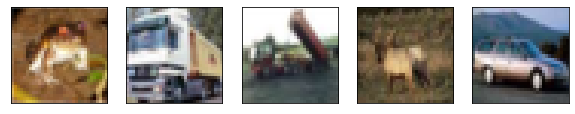

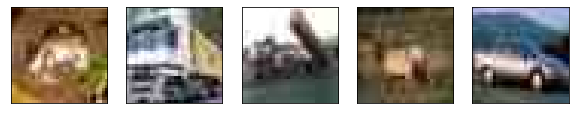

In [5]:
train_batch_5 = train_dataset.batch(5).make_one_shot_iterator().get_next()
train_batch_corrupt_5 = train_dataset_corrupt.batch(5).make_one_shot_iterator().get_next()

# with tf.Session() as sess:
#     train_shape = sess.run(train_batch_5.shape)
    
# print(train_shape)
print(train_batch_5.shape)
print(train_batch_5.get_shape())
# print(train_batch.set_shape())

# myplot(train_batch)
myplot(train_batch_5)
myplot(train_batch_corrupt_5)


In [8]:
import tensorflow as tf
tf.enable_eager_execution()

from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, SpatialDropout2D, ReLU
from tensorflow.keras.models import Model


def _conv_block(inputs, filters=32, kernel_size=(3, 3), strides=(1, 1), conv_id=1, dropout=False):
  x = Conv2D(filters, kernel_size, strides, 
                             activation='relu', 
                             padding='same',
                             name=f'conv{conv_id}')(inputs)
  if dropout:
    return SpatialDropout2D(0.2)(x)
  return x

def _deconv_block(inputs, filters=32, kernel_size=(3, 3), strides=(1, 1), deconv_id=1, dropout=False):
  x = Conv2DTranspose(filters, kernel_size, strides, 
                             activation='relu', 
                             padding='same',
                             name=f'deconv{deconv_id}')(inputs)
  if dropout:
    return SpatialDropout2D(0.2)(x)
  return x

def _skip_block(input1, input2, skip_id=1):
  x = tf.keras.layers.add([input1, input2])
  return ReLU(name=f'skip{skip_id}_relu')(x)

# Some helper functions for getting layers from models
def get_model_layer(model, name=None, index=None):
  return model.get_layer(name=name, index=index)

def get_layer_index(model, name=None):
  return model.layers.index(model.get_layer(name))

def get_layer_output_shape(model, name=None, index=None, output_idx=0):
  output = model.get_layer(name=name, index=index).get_output_at(output_idx)
  batch = output.shape[0]
  shape = output.shape[1:]
  return shape, output

In [9]:
debug = False
enable_skip = False

n_conv_layers = 5
INPUT_SHAPE = (32, 32, 3)
# INPUT_SHAPE = (64, 64, 3)


# Define number of deconv layers and skip connection frequency
n_deconv_layers = n_conv_layers
n_skip = 2



encoder_inputs = Input(shape=INPUT_SHAPE, dtype='float32', name="encoder_inputs") # inputs skips to end
# conv = encoder_inputs
# conv = tf.Placeholder()

for i in range(n_conv_layers):
  conv_idx = i + 1
  if conv_idx == 1:
    conv = _conv_block(encoder_inputs, conv_id=conv_idx)
  else:
    conv = _conv_block(conv, conv_id=conv_idx)

encoded = conv
encoder = Model(inputs=encoder_inputs, outputs=encoded, name='encoder')

# Build Encoder layer and output lists
encoder_outputs = [layer.output for layer in encoder.layers]
encoder_layers = [layer for layer in encoder.layers]

if debug:
  for i, out in enumerate(encoder_outputs):
    print(i, out)
  print()

# encoded_output_shape = encoded.shape[1:]
# decoder_inputs = Input(shape=encoded_output_shape, dtype='float32', name="decoder_inputs")

for i, skip in enumerate(reversed(encoder_outputs[:-1])):
  deconv_idx = i + 1
  deconv_filters = 32
  if deconv_idx == n_deconv_layers:
    deconv_filters = 3
  
  if deconv_idx == 1:
    #deconv = _deconv_block(decoder_inputs, filters=deconv_filters, deconv_id=deconv_idx)
    deconv = _deconv_block(encoded, filters=deconv_filters, deconv_id=deconv_idx)
    if debug: print(f"Deconv... \t deconv_idx: {deconv_idx}, filters: {deconv_filters}, shape: {deconv.shape[1:]}, input_name: '{encoded.name}', deconv_name: '{deconv.name}'")
  else:
    deconv = _deconv_block(deconv, filters=deconv_filters, deconv_id=deconv_idx)
    if debug: print(f"Deconv... \t deconv_idx: {deconv_idx}, filters: {deconv_filters}, shape: {deconv.shape[1:]}, input_name: '{deconv.name}', deconv_name: '{deconv.name}'")  
  
  if enable_skip:
    if deconv_idx % n_skip == 0:
      skip_num = deconv_idx // n_skip
      if debug: print(f"Skip... \t deconv_idx: {deconv_idx}, skip #: {skip_num}, conv_shape: {skip.shape[1:]}, deconv_shape: {deconv.shape[1:]} \n\t\t conv: '{skip.name}', deconv: '{deconv.name}'")
      #assert deconv.shape == skip.shape
      deconv = _skip_block(deconv, skip, skip_id=skip_num)
      if debug: print(f"Added... \t deconv_idx: {deconv_idx}, filters: {deconv_filters}, shape: {deconv.shape[1:]}\n")

decoded = deconv #(decoder_inputs)
# decoder = Model(inputs=decoder_inputs, outputs=decoded(decoder_inputs), name='decoder')

# Create autoencoder model
model = Model(inputs=encoder_inputs, outputs=decoded, name=f'REDNet{n_conv_layers}')

# Create decoder model
encoded_input = Input(shape=encoded.shape[1:])
decoder_layer = model.layers[-1]
decoder = Model(encoded_input, decoder_layer(encoded_input))

# Build layer and output lists
encoder_outputs = [layer.output for layer in encoder.layers]
encoder_layers = [layer for layer in encoder.layers]

if debug:
  for i, out in enumerate(encoder_outputs):
    print(i, out)
  print()

# Build layer and output lists
decoder_outputs = [layer.output for layer in decoder.layers]
decoder_layers = [layer for layer in decoder.layers]

if debug:
  for i, out in enumerate(decoder_layers):
    print(i, out)
  print()

# Build layer and output lists
model_outputs = [layer.output for layer in model.layers]
model_layers = [layer for layer in model.layers]

if debug:
  for i, out in enumerate(model_outputs):
    print(i, out)
  print()

In [11]:
optimizer = tf.keras.optimizers.Adam(lr=0.001)

# Compile Model and fit
model.compile(optimizer, 
              loss=tf.keras.losses.MeanSquaredError(), 
              metrics=['acc', 'mse', 'mae'])

In [2]:
myplot(test_batch[:5])
myplot(test_corrupt_batch[:5])
myplot(model.predict(test_corrupt_batch[:5]))

C:\Users\Patrick\Anaconda3\envs\tf-gpu\python.exe
C:\Users\Patrick\AppData\Local\Microsoft\WindowsApps\python.exe
C:\Users\Patrick\Anaconda3\python.exe
